In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import cv2
import matplotlib.pyplot as plt


In [28]:
num_train_sequences = len(train_doc)
num_val_sequences=len(val_doc)

In [4]:
import numpy as np
import os
from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import tensorflow as tf 
import cv2
import matplotlib.pyplot as plt


In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
#!unzip /content/drive/MyDrive/Project_data.zip -d /content/drive/MyDrive/

In [7]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size =10 #experiment with the batch size

In [8]:


def generator(source_path, folder_list, batch_size,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)  
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches =  len(t)//batch_size
        for batch in range(num_batches): 
                batch_data, batch_labels= process_batch(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
        
        if (remaining_seq != 0):
                batch_data, batch_labels= process_batch(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels     

In [10]:
def process_batch(source_path,t,batch,batch_size,img_idx,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,channels)) 
        batch_labels = np.zeros((seq_len,num_classes))    
        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                size=(image_height,image_width)
                image_resized=cv2.resize(image, size)          
                batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1          
        return(batch_data,batch_labels)

In [11]:
##Model

In [12]:
!pip install keras-on-lstm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-on-lstm: filename=keras_on_lstm-0.8.0-py3-none-any.whl size=10974 sha256=13a318207d1a0d7d8229818e12a6c1bfaa3dd9095a6601cbe728553b76be47b1
  Stored in directory: /root/.cache/pip/wheels/ec/74/7b/70f78167943b308f038daf16f742ed249727280b68499412c9
Successfully built keras-on-lstm


In [13]:
from keras.models import Sequential, Model
from keras.layers import Dropout,Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


In [14]:
# Setting image properties 
image_height=160
image_width=160
channels=3
num_classes=5
total_frames=30
frames_to_sample=20
batch_size=40
num_epochs=30 #getting it to 30 epochs because of 30 photo frames
dense_neurons=64
dropout=0.25
filtersize=(3,3,3)
print ('No of Epochs =', num_epochs)

No of Epochs = 30


In [20]:
model = Sequential()
#layer1
model.add(Conv3D(16, (3, 3, 3), padding='same',
input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#layer2
model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


#layer3
model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#layer4
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Flatten
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='tanh'))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

In [19]:
train_path='/content/drive/MyDrive/Project_data/train'
val_path='/content/drive/MyDrive/Project_data/val'

In [20]:
train_generate = generator(train_path, train_doc, batch_size)
val_generate= generator(val_path, val_doc, batch_size)

In [21]:
curr_dt_time = datetime.datetime.now()

In [34]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:01d}-{loss:0.5f}-{categorical_accuracy:0.5f}-{val_loss:.5f}-{val_categorical_accuracy:0.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, save_best_only=False,
                             save_weights_only=False, mode='auto', save_frequency=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [35]:
num_train_sequences=len(train_doc)
num_val_sequences=len(val_doc)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [36]:
steps_per_epoch

17

In [37]:
validation_steps

3

In [38]:
model1 = model.fit(train_generate, steps_per_epoch=17, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generate, 
                    validation_steps=3,class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 5.1397 - categorical_accuracy: 0.1493Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2022-11-2007_38_08.365774/model-1-5.13969-0.14932-7.25314-0.18000.h5
17/17 [==============================] - 95s 5s/step - loss: 5.1397 - categorical_accuracy: 0.1493 - val_loss: 7.2531 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 4.8741 - categorical_accuracy: 0.2172
Epoch 2: saving model to model_init_2022-11-2007_38_08.365774/model-2-4.87414-0.21719-7.49326-0.17000.h5
17/17 [==============================] - 78s 5s/step - loss: 4.8741 - categorical_accuracy: 0.2172 - val_loss: 7.4933 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 5.0013 - categorical_accuracy:

In [47]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

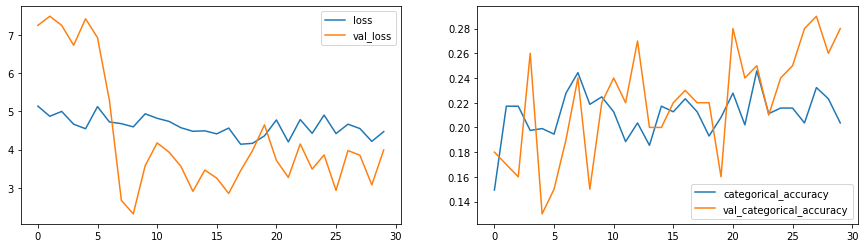

In [48]:
plot(model1)

In [ ]:
#Model2

# Model 2
image_height=160



1. image_width=160
2. channels=3
3. num_classes=5
4. total_frames=30
5. frames_to_sample=15
6. batch_size=30
7. num_epochs=23 #getting it to 30 epochs because of 30 photo 
* frames
* dense_neurons=64
* dropout=0.6
* filtersize=(2,2,2)



In [60]:
#image properties 
image_height=120
image_width=120
channels=3
num_classes=5
total_frames=30
frames_to_sample=16
batch_size=45
num_epochs=30
dense_neurons=256
dropout=0.5
filtersize=(2,2,2)
print ('Number of epochs =', num_epochs)

Number of epochs = 30


In [61]:
model2 = Sequential()
model2.add(Conv3D(16, filtersize, padding='same',
input_shape=(frames_to_sample,image_height,image_width,channels)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(128, filtersize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(dense_neurons,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(dropout))

model2.add(Dense(dense_neurons,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(dropout))


model2.add(Dense(num_classes,activation='softmax'))
        
optimiser = tf.optimizers.Adam(lr=0.0002)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [62]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 8, 60, 60, 32)    

In [63]:

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:01d}-{loss:0.5f}-{categorical_accuracy:0.5f}-{val_loss:.5f}-{val_categorical_accuracy:0.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, save_best_only=False,
                             save_weights_only=False, mode='auto', save_frequency=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [65]:
model2 = model2.fit_generator(train_generate, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generate, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 2.3063 - categorical_accuracy: 0.3150
Epoch 1: saving model to model_init_2022-11-2007_38_08.365774/model-1-2.30628-0.31500-1.63810-0.21000.h5
15/15 [==============================] - 61s 4s/step - loss: 2.3063 - categorical_accuracy: 0.3150 - val_loss: 1.6381 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 1.4940 - categorical_accuracy: 0.4923
Epoch 2: saving model to model_init_2022-11-2007_38_08.365774/model-2-1.49400-0.49228-2.11243-0.24000.h5
15/15 [==============================] - 71s 5s/step - loss: 1.4940 - categorical_accuracy: 0.4923 - val_loss: 2.1124 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 1.0469 - categorical_accuracy: 0.6278
Epoch 3: saving model to model_init_2022-11-2007_38_08.365774/model-3-1.04693-0.62779-2.80079-0.22000.h5
15/15 [====================

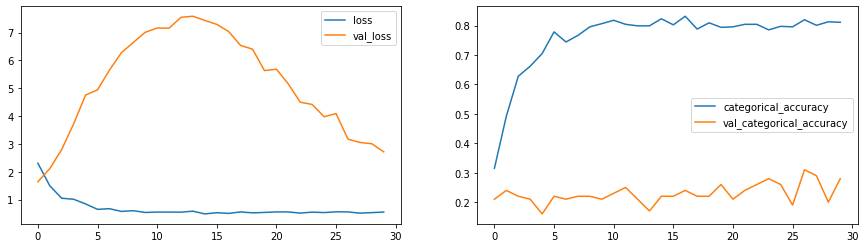

In [71]:
plot(model2)

## Transfer Learning


In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(10,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.30))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.30))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.02)))
model.add(Activation('relu'))
model.add(Dropout(0.30))
model.add(Dense(5))
model.add(Activation('softmax'))

In [24]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])

# summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 10, 50, 50, 16)   208       
 tributed)                                                       
                                                                 
 activation_6 (Activation)   (None, 10, 50, 50, 16)    0         
                                                                 
 batch_normalization_4 (Batc  (None, 10, 50, 50, 16)   64        
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 49, 49, 16)   1040      
 tributed)                                                       
                                                                 
 activation_7 (Activation)   (None, 10, 49, 49, 16)    0         
                                                      

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
e = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False,
                             save_weights_only=False, mode='auto', save_freq=1)

#LR code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.02)
callbacks_list = [checkpoint]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
tf= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5384 - categorical_accuracy: 0.2836  Source path =  /content/gdrive/My Drive/Colab Notebooks/GestureRecognition/Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1519_52_59.500549/model-00001-1.53836-0.28356-1.51678-0.29000.h5
34/34 [==============================] - 5988s 181s/step - loss: 1.5384 - categorical_accuracy: 0.2836 - val_loss: 1.5168 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4082 - categorical_accuracy: 0.3680
Epoch 2: saving model to model_init_2022-05-1519_52_59.500549/model-00002-1.40825-0.36802-1.51568-0.25000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.4082 - categorical_accuracy: 0.3680 - val_loss: 1.5157 - val_categorical_accuracy: 0.2500 - lr: 0

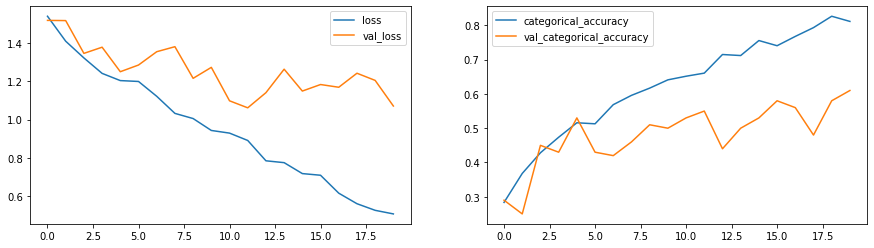

In [39]:
plot(tf)